# Artificial Neural Networks and Deep Learning



---



## Homework 2: 

## ⚙️ Import Libraries

In [26]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ConvNeXtBase
seed = 42
np.random.seed(42)
tf.random.set_seed(42)

# custom module for augmentation
import sys
sys.path.append('/kaggle/input/augment/')
from AugmentationHelper import apply_total_transform, apply_intensity_transform, apply_geometric_transform

## ⏳ Load the Data

In [27]:
# file_path = "/kaggle/input/mars-data/mars_for_students.npz"
file_path = "/kaggle/input/marsdata/mars_for_students_cleaned.npz"

data = np.load(file_path)

training_set = data["training_set"]
images = training_set[:, 0]
labels = training_set[:, 1]

images = images.astype(np.uint8)
labels = labels.astype(np.uint8)

print(f"Training X shape: {images.shape}")
print(f"Training y shape: {labels.shape}")

Training X shape: (2102, 64, 128)
Training y shape: (2102, 64, 128)


### Some exploration (ignore)

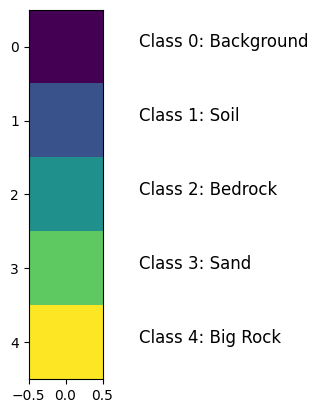

In [28]:
# Labels dictionary
labels_map = {
    0: 'Background',
    1: 'Soil',
    2: 'Bedrock',
    3: 'Sand',
    4: 'Big Rock'
}

plt.imshow([[i] for i in range(5)])
for i in range(5):
    plt.text(1, i, f'Class {i}: {labels_map[i]}', fontsize=12)

plt.show()

In [29]:
n_samples = images.shape[0]
n_samples

2102

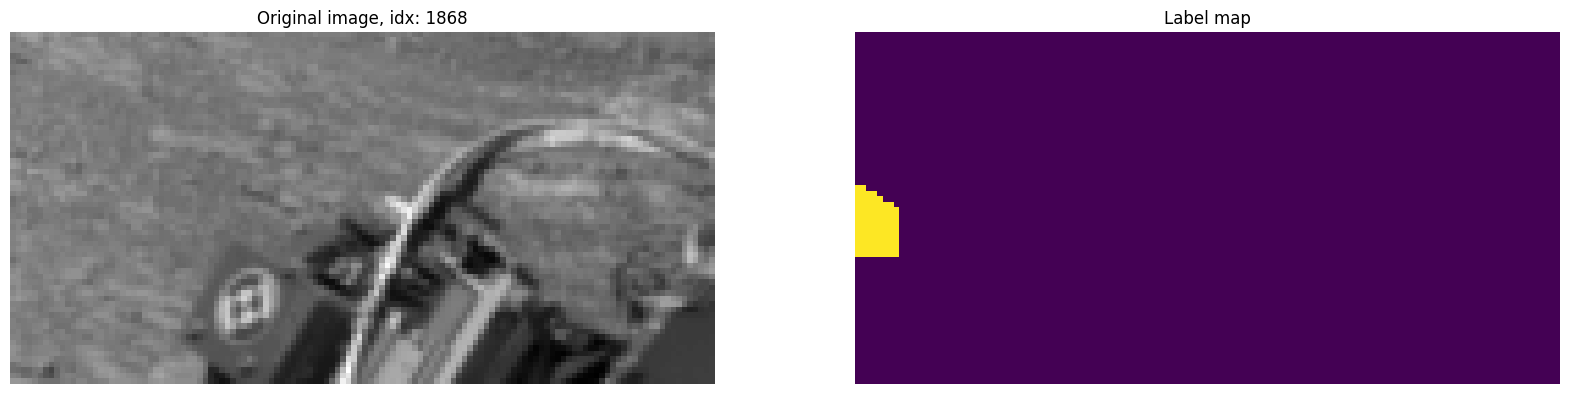

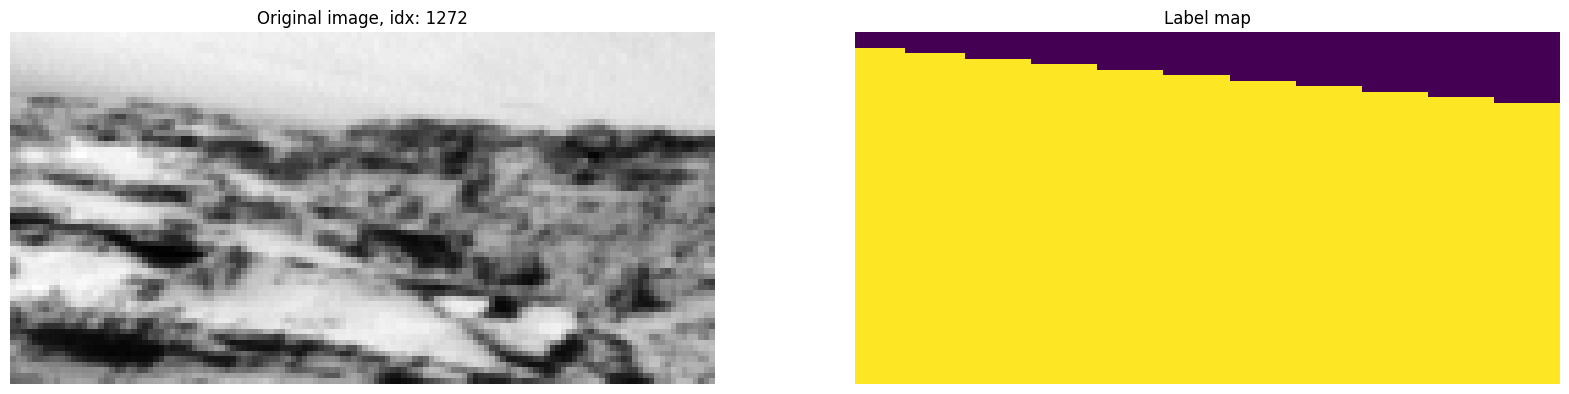

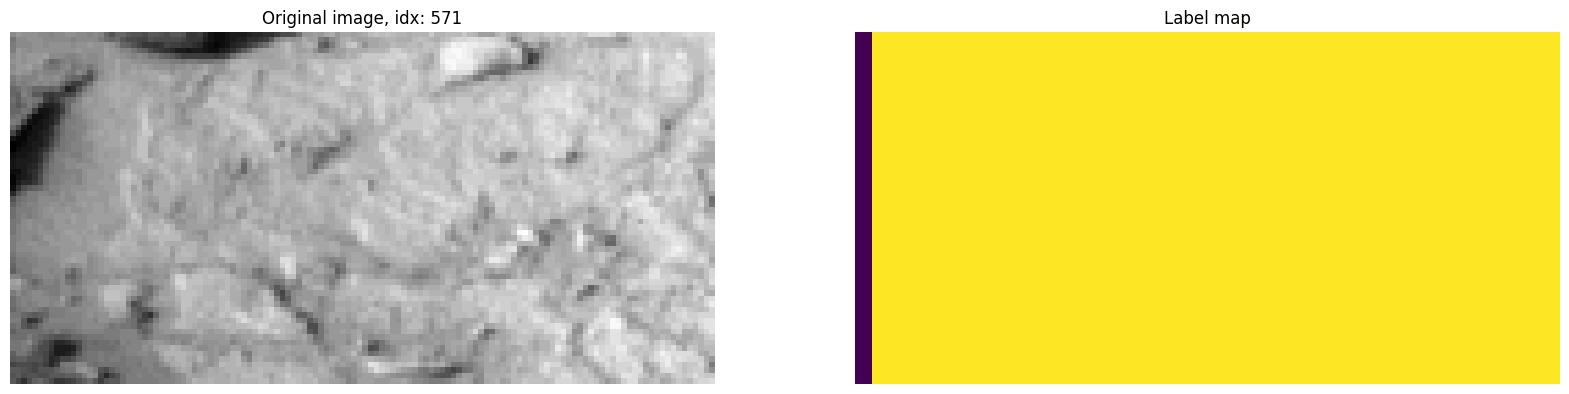

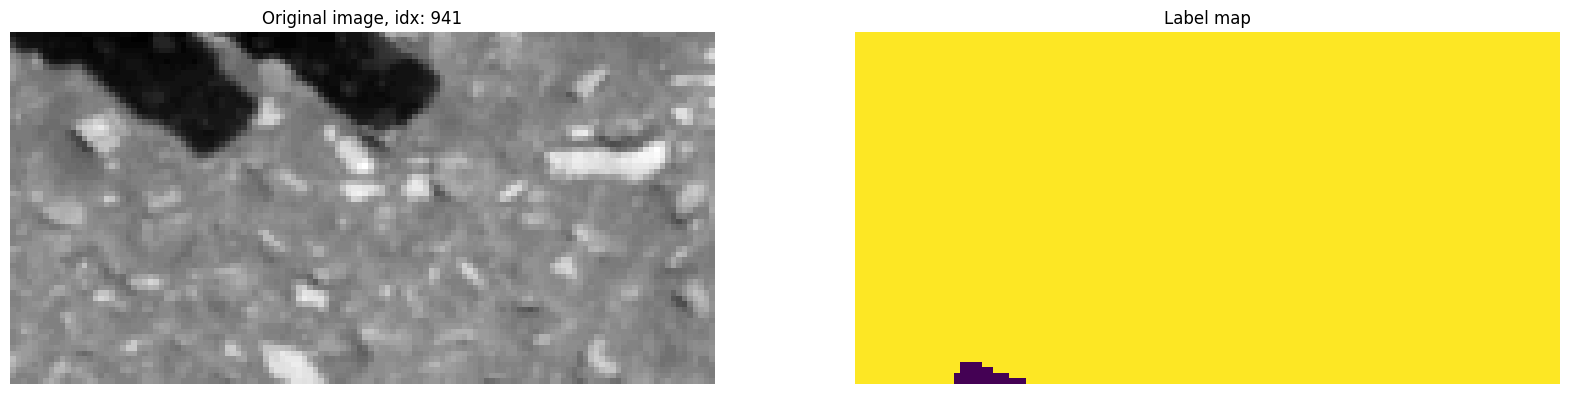

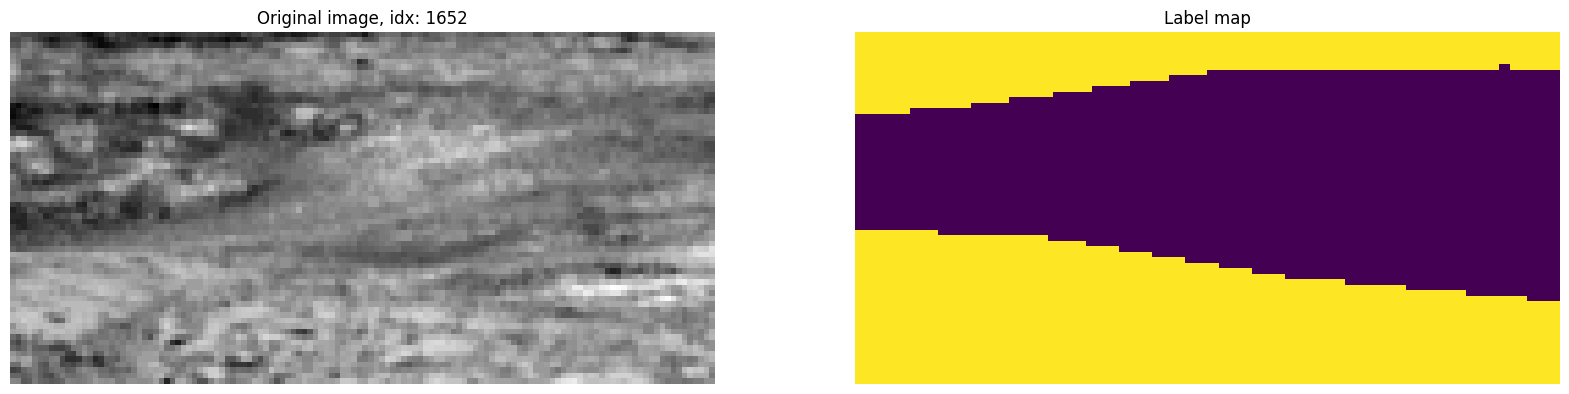

In [30]:
rand_samples = np.random.choice(n_samples, size=5, replace=False)
for sample in rand_samples:
    plt.figure(figsize=(20, 5))
    plt.subplot(121), plt.imshow(images[sample],cmap='gray'), plt.title(f'Original image, idx: {sample}'), plt.axis('off')
    plt.subplot(122), plt.imshow(labels[sample]), plt.title('Label map'), plt.axis('off')
    plt.show()

## Prepare for Binary Segmentation

In [31]:
class_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}

for i in range(len(labels)):
    count = np.bincount(labels[i].flatten(), minlength=5)
    
    if len(np.where(count == 0)[0]) == 3: # there are 3 zeros, ie there is only background and one more class
        idx = np.where(count[1:] != 0)[0][0] + 1 # index of the class
        class_dict[idx].append(i)
    elif len(np.where(count == 0)[0]) == 4: # there are 4 zeros, ie there is only background or one class
        idx = np.where(count != 0)[0][0] # index of the class
        class_dict[idx].append(i)
    else: # more than 2 class is present
        idxs = np.where(count[1:] != 0)[0] # indexes of the classes
        for idx in idxs:
            class_dict[idx+1].append(i)

for i in range(5):
    print("Class", i, "has", len(class_dict[i]), "pictures")

Class 0 has 4 pictures
Class 1 has 1120 pictures
Class 2 has 937 pictures
Class 3 has 699 pictures
Class 4 has 48 pictures


## Data splitting Functions

In [33]:
# Set number of classes
NUM_CLASSES = 2

# Set batch size for training
BATCH_SIZE = 4

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 10

# Set maximum number of training epochs
EPOCHS = 1000

## Preprocessing Functions

In [34]:
def load_single_image(image, label, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape.
    """
    # Read and preprocess the image
    image = tf.cast(image, tf.float32)
    image = image[..., np.newaxis] / 255.0
    image = tf.image.grayscale_to_rgb(image)

    # Read and preprocess the label
    label = tf.cast(label, tf.int32)
    label = label[..., np.newaxis]
    return image, label

In [9]:
category_map = {0:0, 1:1, 2:2, 3:3, 4:4}

def apply_category_mapping(label):

    """Apply category mapping to labels."""

    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )

    return table.lookup(label) #@tf.function


In [10]:
# Note: If we are not able to integrate the module, let's add it like this
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [11]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))    
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Load images and labels
    dataset = dataset.map(
        load_single_image,
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        # Note: If we are not able to integrate the module, let's add it like this
        dataset = dataset.map(
            lambda x, y: random_flip(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        ) 
        
    # Apply category mapping
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [12]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j])
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
#print("Visualizing examples from the training set:")
#plot_sample_batch(train_dataset, num_samples=3)

## Build the Models

### Attention U-Net

In [13]:
def attention_block(x, g, inter_channel):
    # Generate query, key, and value tensors
    theta_x = tfkl.Conv2D(inter_channel, (1,1), padding='same')(x)   # Query
    phi_g = tfkl.Conv2D(inter_channel, (1,1), padding='same')(g)      # Key
    attn = tfkl.Activation('sigmoid')(tfkl.Add()([theta_x, phi_g]))   # Attention Map
    attn = tfkl.Conv2D(1, (1,1), padding='same')(attn)  # Value

    # Multiply attention map with the input feature map
    return tfkl.Multiply()([x, attn])


def attention_u_net(input_shape, depth=4, d_conv_count=3, b_conv_count=3, u_conv_count=3, start_filter=32, skip_connections=True, dropout=0.2, NUM_CLASSES=NUM_CLASSES):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []

    # Downsampling
    for i in range(depth):

        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2, 2))(x)
        x = tfkl.Dropout(dropout)(x)

        start_filter = start_filter * 2

    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                        kernel_size=(3, 3),
                        strides=(1, 1),
                        padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)

    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):

        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            # Apply attention mechanism to the skip connections
            x = attention_block(x, skipped[depth - i - 1], start_filter)

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3, 3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        start_filter = start_filter // 2

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                          kernel_size=(1, 1),
                          strides=(1, 1),
                          padding='same',
                          activation='softmax',
                          name="output_layer")(x)

    model = Model(inputs, outputs, name='Attention_UNet')
    return model


### Regular U-Net

In [14]:
def u_net(input_shape, depth=4, 
          d_conv_count = 3, b_conv_count = 3, u_conv_count = 3, 
          start_filter=32, skip_connections=True, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    x = inputs
    skipped = []
    # Downsampling
    for i in range(depth):
        for j in range(d_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) 
            x = tfkl.ReLU()(x)

        if skip_connections:
            # Save the layer for skip connections
            skipped.append(x)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(x)
        x = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    for j in range(b_conv_count):
        x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
        x = tfkl.BatchNormalization()(x) 
        x = tfkl.ReLU()(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(x)

        if skip_connections:
            x = tfkl.Concatenate()([x, skipped[depth - i - 1]])

        x = tfkl.Dropout(dropout)(x)

        for j in range(u_conv_count):
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            strides=(1, 1),
                            padding='same')(x)
            x = tfkl.BatchNormalization()(x) ## remove?
            x = tfkl.ReLU()(x)
        start_filter = start_filter // 2
    

    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='softmax',
                        name="output_layer")(x)
    
    model = tf.keras.Model(inputs, outputs, name='UNet')
    return model

### Dense U-Net

In [15]:
'''
References:
Paper: https://qims.amegroups.org/article/view/43519/html
Code: https://github.com/THUHoloLab/Dense-U-net/blob/master/Dense-U-net/Dense_U_net.py
'''

def dense_unet(input_shape, depth=4, 
               d_conv_count = 3, u_conv_count = 3,
               start_filter=32, dropout=0.2):

    # Input Layer
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    next = inputs
    skipped = []

    # Downsampling
    for i in range(depth):
        # Now this is a Dense Block
        for j in range(d_conv_count):
            
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            kernel_initializer="he_normal",
                            strides=(1, 1),
                            padding='same')(next)
            x = tfkl.BatchNormalization()(x) 
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next]) 

        
        skipped.append(conv_block)

        x = tfkl.MaxPooling2D(pool_size=(2,2))(conv_block)
        next = tfkl.Dropout(dropout)(x)
        
        start_filter = start_filter * 2
    
    # Bottleneck
    x = tfkl.Conv2D(filters=start_filter,
                        kernel_size=(3,3),
                        strides=(1, 1),
                        kernel_initializer="he_normal",
                        padding='same')(next)
    x = tfkl.BatchNormalization()(x) ##### not sure
    x = tfkl.ReLU()(x)
    next = tfkl.Dropout(dropout)(x)
    
    start_filter = start_filter // 2

    # Upsampling
    for i in range(depth):
        x = tfkl.UpSampling2D(2, interpolation='bilinear')(next)
        x = tfkl.Concatenate()([x, skipped.pop()]) ## try without axis
        next = tfkl.Dropout(dropout)(x)

        # Dense Block again
        for j in range(u_conv_count):
            
            x = tfkl.Conv2D(filters=start_filter,
                            kernel_size=(3,3),
                            kernel_initializer="he_normal",
                            strides=(1, 1),
                            padding='same')(next)            
            x = tfkl.BatchNormalization()(x) 
            conv_block = tfkl.ReLU()(x)
            next = tfkl.Concatenate()([conv_block, next]) 
            
        start_filter = start_filter // 2
    
    # Output Layer
    outputs = tfkl.Conv2D(filters=NUM_CLASSES,
                        kernel_size=(1,1),
                        strides=(1, 1),
                        padding='same',
                        activation='sigmoid',
                        name="output_layer")(next)
    
    model = tf.keras.Model(inputs, outputs, name='Dense_UNet')
    return model
    

### Metrics

In [16]:
# Define custom Mean Intersection Over Union metric

class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):

    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):

        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)

        if labels_to_exclude is None:

            labels_to_exclude = [0]  # Default to excluding label 0

        self.labels_to_exclude = labels_to_exclude



    def update_state(self, y_true, y_pred, sample_weight=None):

        # Convert predictions to class labels

        y_pred = tf.math.argmax(y_pred, axis=-1)



        # Flatten the tensors

        y_true = tf.reshape(y_true, [-1])

        y_pred = tf.reshape(y_pred, [-1])



        # Apply mask to exclude specified labels

        for label in self.labels_to_exclude:

            mask = tf.not_equal(y_true, label)

            y_true = tf.boolean_mask(y_true, mask)

            y_pred = tf.boolean_mask(y_pred, mask)



        # Update the state

        return super().update_state(y_true, y_pred, sample_weight)

In [17]:
# https://stackoverflow.com/questions/65125670/implementing-multiclass-dice-loss-function
def dice_loss(y_true, y_pred, smooth=1e-7):
    '''
    Dice coefficient for X categories. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=NUM_CLASSES)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss_multiclass(y_true, y_pred):
    '''
    Dice loss to minimize. Pass to model as loss during compile statement
    '''
    return 1 - dice_loss(y_true, y_pred)

def combined_multiclass_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    dice = dice_loss_multiclass(y_true, y_pred)
    categorical_ce = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    return alpha * dice + beta * categorical_ce

## 🛠️ Train the Model

In [23]:
class_dict = {0:[], 1:[], 2:[], 3:[], 4:[]}

for i in range(len(labels)):
    count = np.bincount(labels[i].flatten(), minlength=5)
    
    if len(np.where(count == 0)[0]) == 3: # there are 3 zeros, ie there is only background and one more class
        idx = np.where(count[1:] != 0)[0][0] + 1 # index of the class
        class_dict[idx].append(i)
    elif len(np.where(count == 0)[0]) == 4: # there are 4 zeros, ie there is only background or one class
        idx = np.where(count != 0)[0][0] # index of the class
        class_dict[idx].append(i)
    else: # more than 2 class is present
        idxs = np.where(count[1:] != 0)[0] # indexes of the classes
        for idx in idxs:
            class_dict[idx+1].append(i)

for i in range(5):
    print("Class", i, "has", len(class_dict[i]), "pictures")

Class 0 has 4 pictures
Class 1 has 1120 pictures
Class 2 has 937 pictures
Class 3 has 699 pictures
Class 4 has 48 pictures


Number of images
Train: 		1067
Validation: 	57
Size of train dataset after augmentation 4268
Creating datasets...
Datasets created!
Compiling model...
Model compiled!
Epoch 1/1000
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 70s 31ms/step - accuracy: 0.6890 - loss: 0.2162 - mean_iou: 0.4861 - val_accuracy: 0.6539 - val_loss: 0.2271 - val_mean_iou: 0.4999 - learning_rate: 0.0010
Epoch 2/1000
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6994 - loss: 0.1913 - mean_iou: 0.7753 - val_accuracy: 0.6541 - val_loss: 0.2268 - val_mean_iou: 0.5000 - learning_rate: 0.0010
Epoch 3/1000
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6992 - loss: 0.1913 - mean_iou: 1.0000 - val_accuracy: 0.6540 - val_loss: 0.2268 - val_mean_iou: 0.5000 - learning_rate: 0.0010
Epoch 4/1000
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step - accuracy: 0.6992 - loss: 0.1925 - mean_iou: 1.0000 - val_accuracy: 0.6541 - val_loss: 0.2268 - val_mean_iou: 0.5000 - learning_rate: 0.0010
Epoch 5/1000
1067/1067 ━━━━━━━━━━

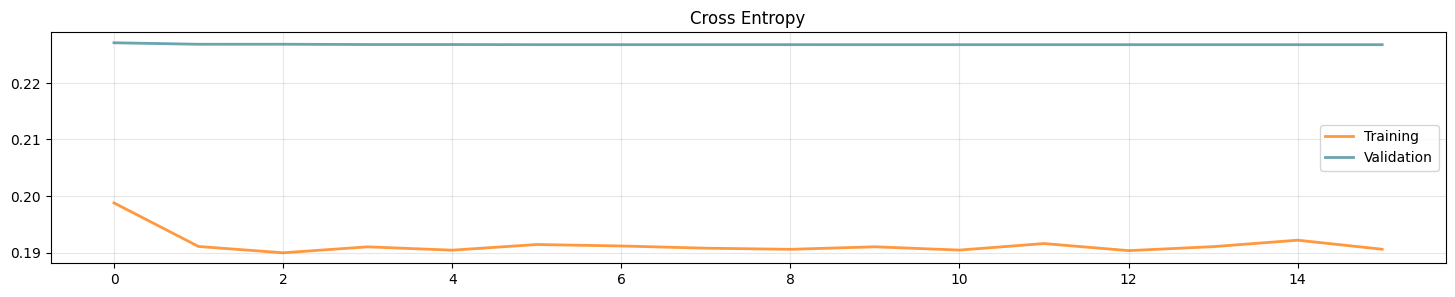

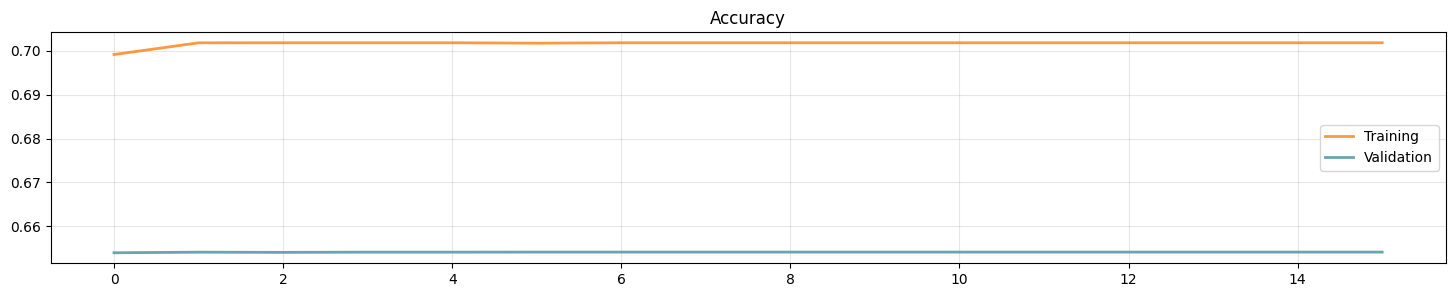

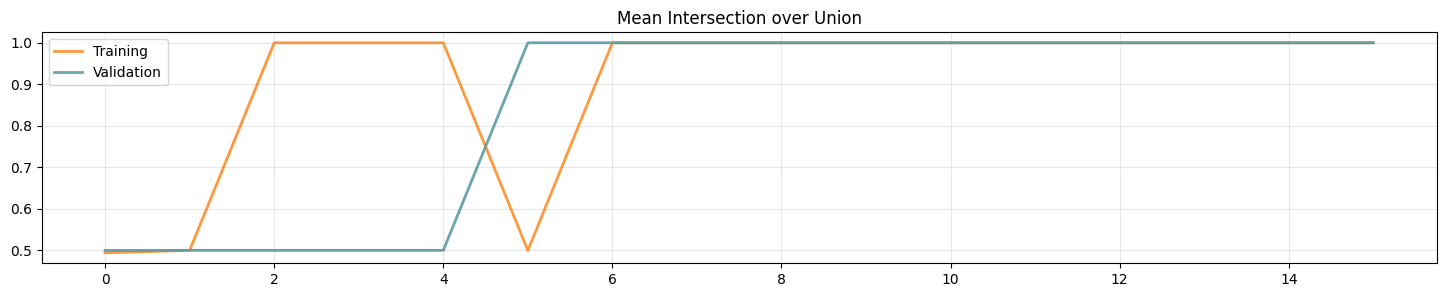

Number of images
Train: 		893
Validation: 	48
Size of train dataset after augmentation 3572
Creating datasets...
Datasets created!
Compiling model...
Model compiled!
Epoch 1/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 63s 30ms/step - accuracy: 0.6016 - loss: 0.3477 - mean_iou: 0.4190 - val_accuracy: 0.4765 - val_loss: 0.3890 - val_mean_iou: 0.4615 - learning_rate: 0.0010
Epoch 2/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5865 - loss: 0.3240 - mean_iou: 0.4583 - val_accuracy: 0.6314 - val_loss: 0.3239 - val_mean_iou: 0.4291 - learning_rate: 0.0010
Epoch 3/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5990 - loss: 0.3159 - mean_iou: 0.4603 - val_accuracy: 0.6895 - val_loss: 0.2833 - val_mean_iou: 0.4579 - learning_rate: 0.0010
Epoch 4/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.6582 - loss: 0.2968 - mean_iou: 0.4358 - val_accuracy: 0.6725 - val_loss: 0.2857 - val_mean_iou: 0.4742 - learning_rate: 0.0010
Epoch 5/1000
893/893 ━━━━━━━━━━━━━━━━━━━━ 

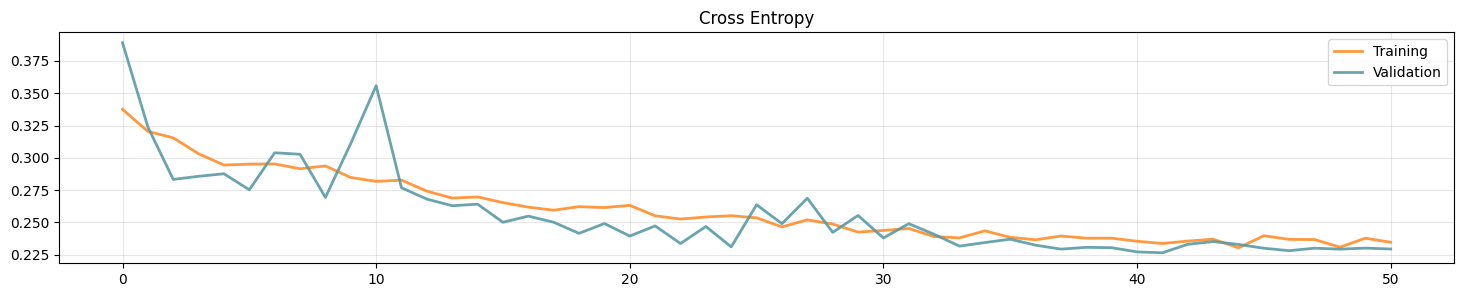

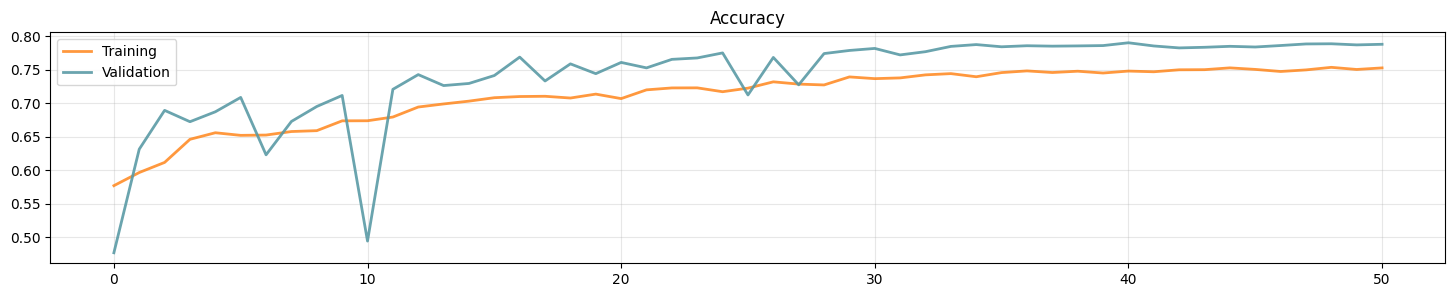

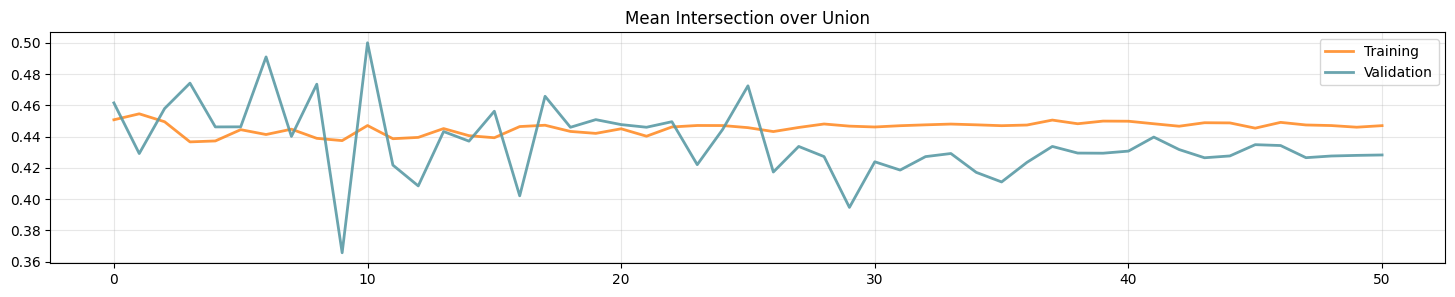

Number of images
Train: 		667
Validation: 	36
Size of train dataset after augmentation 2668
Creating datasets...
Datasets created!
Compiling model...
Model compiled!
Epoch 1/1000
667/667 ━━━━━━━━━━━━━━━━━━━━ 59s 31ms/step - accuracy: 0.7032 - loss: 0.2595 - mean_iou: 0.4311 - val_accuracy: 0.5962 - val_loss: 0.2881 - val_mean_iou: 0.4999 - learning_rate: 0.0010
Epoch 2/1000
667/667 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7436 - loss: 0.2271 - mean_iou: 0.4339 - val_accuracy: 0.7286 - val_loss: 0.2247 - val_mean_iou: 0.4915 - learning_rate: 0.0010
Epoch 3/1000
667/667 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7546 - loss: 0.2199 - mean_iou: 0.4373 - val_accuracy: 0.7451 - val_loss: 0.2176 - val_mean_iou: 0.4815 - learning_rate: 0.0010
Epoch 4/1000
667/667 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.7594 - loss: 0.2148 - mean_iou: 0.4387 - val_accuracy: 0.7371 - val_loss: 0.2190 - val_mean_iou: 0.4928 - learning_rate: 0.0010
Epoch 5/1000
667/667 ━━━━━━━━━━━━━━━━━━━━ 

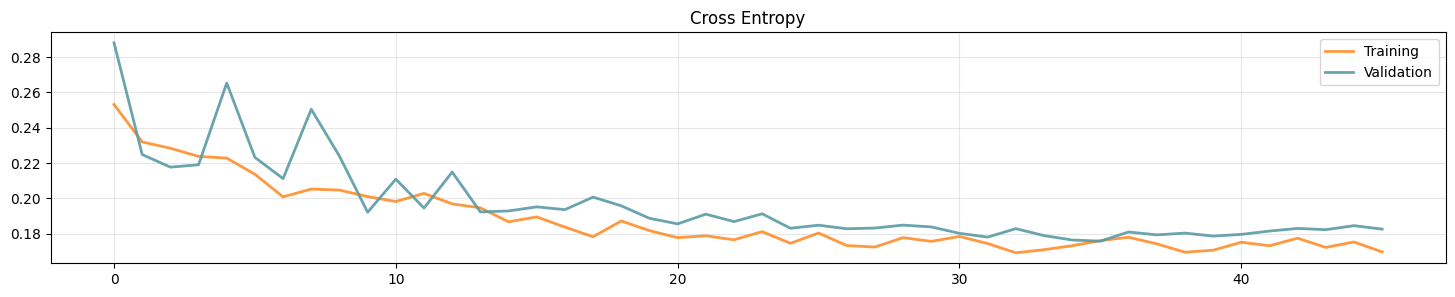

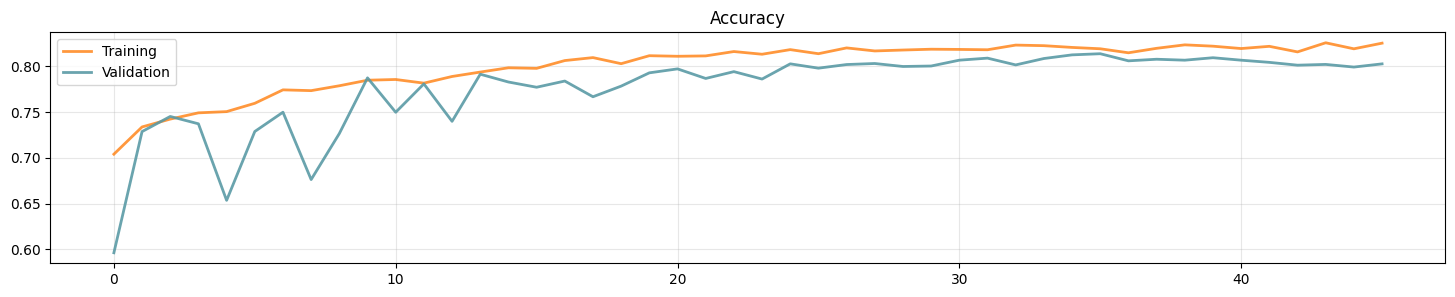

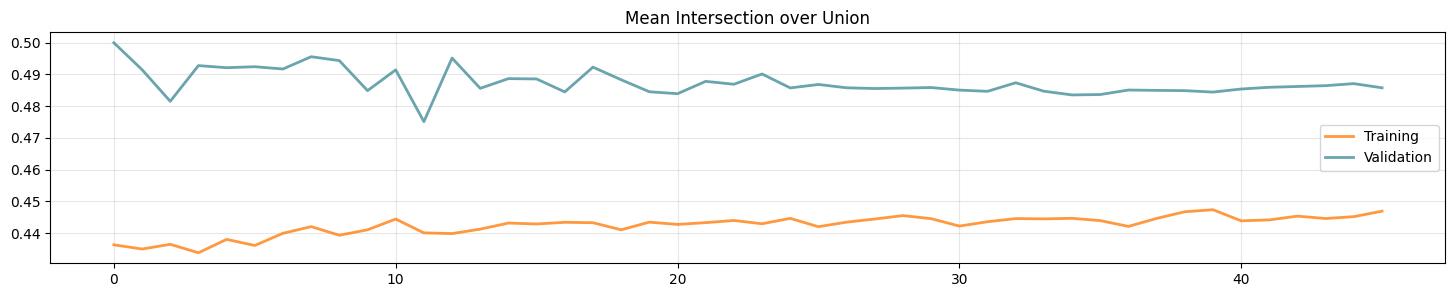

Number of images
Train: 		49
Validation: 	3
Size of train dataset after augmentation 196
Creating datasets...
Datasets created!
Compiling model...
Model compiled!
Epoch 1/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - accuracy: 0.6716 - loss: 0.8856 - mean_iou: 0.3087 - val_accuracy: 0.6735 - val_loss: 0.9335 - val_mean_iou: 0.2725 - learning_rate: 0.0010
Epoch 2/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.7791 - loss: 0.8641 - mean_iou: 0.2617 - val_accuracy: 0.9728 - val_loss: 0.9581 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8093 - loss: 0.8439 - mean_iou: 0.2684 - val_accuracy: 0.9728 - val_loss: 0.9824 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8557 - loss: 0.8056 - mean_iou: 0.2835 - val_accuracy: 0.9728 - val_loss: 0.9851 - val_mean_iou: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 2

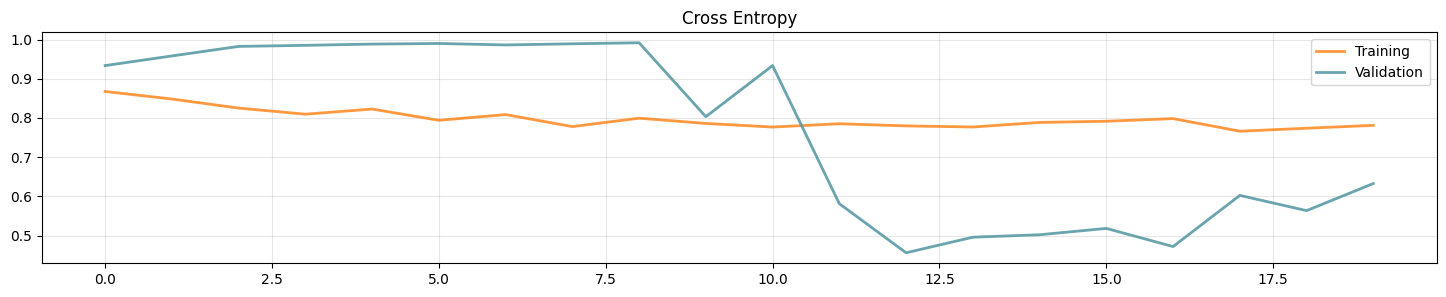

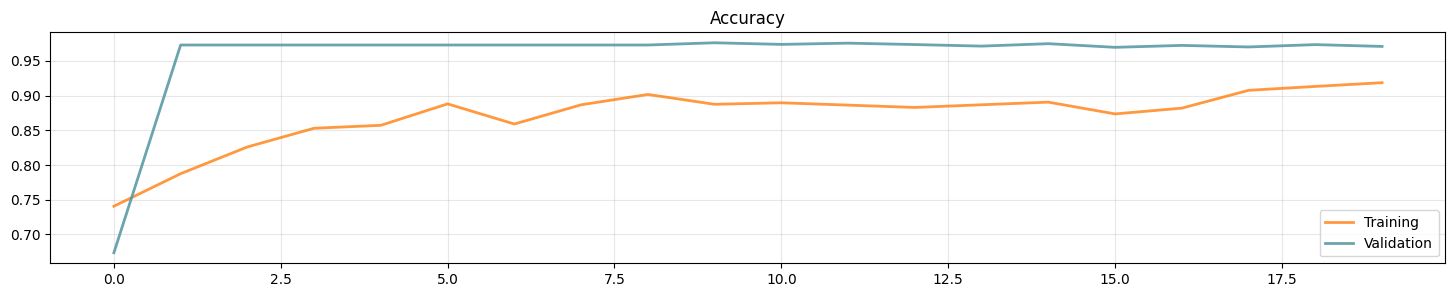

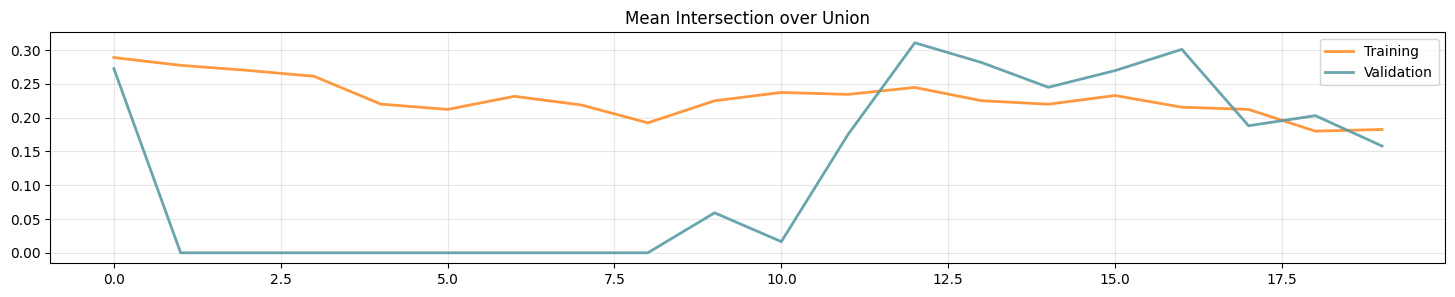

In [35]:
for c in range(1,5):
    #c = 1
    print("Training for class", c)
    class_images = np.concatenate((images[class_dict[0]],images[class_dict[c]]))
    class_labels = np.concatenate((labels[class_dict[0]],labels[class_dict[c]]))
    
    class_labels = np.where(class_labels == c, 1, 0) # if it is our class make it 1, otherwise 0
    
    # 5% of input data to both test and validation sets
    validation_ratio = 0.05 
    
    train_img, val_img, train_lbl, val_lbl= train_test_split(
        class_images, class_labels, test_size=validation_ratio, random_state=seed
    )
    
    print(f"Number of images")
    print(f"Train: \t\t{len(train_img)}")
    print(f"Validation: \t{len(val_img)}")
    
    train_img_i, train_lbl_i = apply_intensity_transform(train_img, train_lbl)
    train_img_g, train_lbl_g = apply_geometric_transform(train_img, train_lbl)
    train_img_t, train_lbl_t = apply_total_transform(train_img, train_lbl)
    
    train_img = np.concatenate((train_img, train_img_i, train_img_g, train_img_t), axis=0)
    train_lbl = np.concatenate((train_lbl, train_lbl_i, train_lbl_g, train_lbl_t), axis=0)
    
    print("Size of train dataset after augmentation", len(train_img))
    
    # Create the datasets
    print("Creating datasets...")
    
    train_dataset = make_dataset(
        train_img, train_lbl,
        batch_size=BATCH_SIZE,
        shuffle=True,
        augment=True,
        seed=seed
    )
    
    val_dataset = make_dataset(
        val_img, val_lbl,
        batch_size=BATCH_SIZE,
        shuffle=False
    )
    
    print("Datasets created!")
    
    for i, l in train_dataset.take(1):
        input_shape = i.shape[1:]
    
    model = u_net(input_shape)
    
    # Print a detailed summary of the model with expanded nested layers and trainable parameters.
    #model.summary(expand_nested=True, show_trainable=True)
    
    
    # Compile the model
    print("Compiling model...")
    
    model.compile(
        loss= dice_loss_multiclass, #combined_multiclass_loss,#keras.losses.CategoricalFocalCrossentropy(), #dice_loss_multiclass, #tf.keras.losses.Dice, #tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )
    
    print("Model compiled!")
    
    # Setup callbacks
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        mode='max',
        patience=PATIENCE,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        mode="auto",
        min_lr=1e-5
    )
    
    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    ).history
    
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')
    
    
    # Save the trained model to a file with the accuracy included in the filename
    
    model_filename = str(c) + '-model.keras'
    model.save(model_filename)
    
    # Delete the model to free up resources
    del model
    
    # Plot and display training and validation loss
    plt.figure(figsize=(18, 3))
    plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Cross Entropy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plot and display training and validation accuracy
    plt.figure(figsize=(18, 3))
    plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Accuracy')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
    
    # Plot and display training and validation mean IoU
    plt.figure(figsize=(18, 3))
    plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
    plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
    plt.title('Mean Intersection over Union')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## Load the Models

In [36]:
# Load UNet model without compiling
model1 = tfk.models.load_model('/kaggle/working/1-model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model1.compile(
    loss=dice_loss_multiclass,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
model2 = tfk.models.load_model('/kaggle/working/2-model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model2.compile(
    loss=dice_loss_multiclass,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
model3 = tfk.models.load_model('/kaggle/working/3-model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model3.compile(
    loss=dice_loss_multiclass,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
model4 = tfk.models.load_model('/kaggle/working/4-model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model4.compile(
    loss=dice_loss_multiclass,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

In [37]:
X_test_submission = data["test_set"]

print(f"Test X shape: {X_test_submission.shape}")
X_test_submission = X_test_submission[..., np.newaxis] / 255.0
X_test_submission = tf.cast(X_test_submission, tf.float32)
X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)

Test X shape: (10022, 64, 128)


In [80]:
prediction = model1.predict(X_test_submission)
prediction = np.argmax(prediction, axis=-1)
prediction1 = np.where(prediction == 1, 1, 0) 

prediction = model2.predict(X_test_submission)
prediction = np.argmax(prediction, axis=-1)
prediction2 = np.where(prediction == 1, 2, 0) 

prediction = model3.predict(X_test_submission)
prediction = np.argmax(prediction, axis=-1)
prediction3 = np.where(prediction == 1, 3, 0) 

prediction = model4.predict(X_test_submission)
prediction = np.argmax(prediction, axis=-1)
prediction4 = np.where(prediction == 1, 4, 0) 

predictions = [prediction1, prediction2, prediction3, prediction4]

# Step 2: Stack predictions along a new axis
stacked_predictions = np.stack(predictions, axis=-1)  # Shape: (H, W, 4)

# Step 3: Resolve overlaps using argmax (for multi-class segmentation)
final_mask = np.argmax(stacked_predictions, axis=-1)  # Shape: (H, W)

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [59]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]


In [60]:
# Create and download the csv submission file

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.csv'

submission_df = y_to_df(final_mask)

submission_df.to_csv(filename, index=False)

filename

'submission_241210_141311.csv'

## 📊 Prepare Your Submission



In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [32]:
X_test_submission = data["test_set"]

print(f"Test X shape: {X_test_submission.shape}")
X_test_submission = X_test_submission[..., np.newaxis] / 255.0
X_test_submission = tf.cast(X_test_submission, tf.float32)
X_test_submission = tf.image.grayscale_to_rgb(X_test_submission)

Test X shape: (10022, 64, 128)


In [33]:
# Load UNet model without compiling

model = tfk.models.load_model('/kaggle/working/model.keras', compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=dice_loss_multiclass,
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 64, 128, │       896 │ input_layer[0… │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d[0][0]   │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu (ReLU)      │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_1[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_1 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 64, 128, │     9,248 │ re_lu_1[0][0]  │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 64, 128, │       128 │ conv2d_2[0][0] │   Y   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_2 (ReLU)    │ (None, 64, 128, │         0 │ batch_normali… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 32, 64,  │         0 │ re_lu_2[0][0]  │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout (Dropout) │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 32, 64,  │    18,496 │ dropout[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_3[0][0] │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ re_lu_3 (ReLU)    │ (None, 32, 64,  │         0 │ batch_normali… │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 32, 64,  │    36,928 │ re_lu_3[0][0]  │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 32, 64,  │       256 │ conv2d_4[0][0] │   Y 

 Total params: 11,271,145 (43.00 MB)

 Trainable params: 11,262,313 (42.96 MB)

 Non-trainable params: 8,832 (34.50 KB)

In [34]:
preds = model.predict(X_test_submission)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step
Predictions shape: (10022, 64, 128)


In [40]:
def y_to_df(y) -> pd.DataFrame:

    """Converts segmentation predictions into a DataFrame format for Kaggle."""

    n_samples = len(y)

    y_flat = y.reshape(n_samples, -1)

    df = pd.DataFrame(y_flat)

    df["id"] = np.arange(n_samples)

    cols = ["id"] + [col for col in df.columns if col != "id"]

    return df[cols]


In [36]:
# Create and download the csv submission file

filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.csv'

submission_df = y_to_df(preds)

submission_df.to_csv(filename, index=False)

filename

'submission_241207_150705.csv'